In [1]:
import random

import cv2
from matplotlib import pyplot as plt
import numpy as np

import albumentations as A
import json

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import math
import pandas as pd

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)>
  data = fetch_version_info()


In [3]:
def get_points(image_dict):
    points = []
    labels = []

    for i in range(len(image_dict['regions'])):
        for j in range(len(image_dict['regions'][i]['shape_attributes']['all_points_x'])):
            curr = (image_dict['regions'][i]['shape_attributes']['all_points_x'][j],
                    image_dict['regions'][i]['shape_attributes']['all_points_y'][j])
            points.append(curr)
            labels.append(str(i))

    return points, labels

In [4]:
def get_lists(keypoints):
    all_points_x = []
    all_points_y = []

    for x, y in keypoints:
        all_points_x.append(x)
        all_points_y.append(y)
    return all_points_x, all_points_y

'photo_2024-10-15_00-09-17_1611'

'photo_2024-10-15_00-09-17_1611'

In [5]:
def visualize_points_sub(image, points):
    prev = points[-1]
    for point in points:
        cv2.line(image, (point[0],point[1]), (prev[0], prev[1]), color=(255, 0, 0),
                 thickness=min(image.shape[0], image.shape[1]) // 300)
        prev = point

def visualize_points(image, points_):
    points, labels = points_
    im_cp = image.copy()
    prev_label = None
    curr_points = []

    for point, label in zip(points, labels):
        if prev_label != None and label != prev_label:
            visualize_points_sub(im_cp, curr_points)
            curr_points = []

        curr_points.append(point)
        prev_label = label

    visualize_points_sub(im_cp, curr_points)
        
    plt.figure(figsize=(8, 10))
    plt.axis('off')
    plt.imshow(im_cp)

In [6]:
def fix_keypoints(keypoints_):
    keypoints = []
    for point in keypoints_:
        keypoints.append((int(point[0]), int(point[1])))
    return keypoints

In [ ]:
two_dym_types = [ 'aztec_code',
        'data_matrix',
        'maxi_code',
        'pdf_417',
        'qr',
        'databar_expanded_stacked',
        'generic2d',
        'generic_mixed',
        'databar_stacked',
        'databar_expanded']


In [8]:
def get_regions(initial_regions, keypoints, labels):
    regions = []
    curr_x, curr_y = [], []
    for i in range(len(labels)):
        curr_x.append(keypoints[i][0])
        curr_y.append(keypoints[i][1])
        if i + 1 == len(labels) or labels[i + 1] != labels[i]:
            curr_dict = dict(initial_regions[int(labels[i])])
            old_len = len(curr_dict['shape_attributes']['all_points_x'])
            curr_dict['shape_attributes']['all_points_x'] = curr_x
            curr_dict['shape_attributes']['all_points_y'] = curr_y
            if len(curr_x) < old_len:
                curr_dict['region_attributes']['code integrity'] = 'invalid'
            regions.append(curr_dict)
            curr_x, curr_y = [], []

    return regions

In [9]:
def visualize(image_path, full_data):
    image_name = image_path.split('/')[-1].split('.')[0]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for full_name, file_data_ in full_data['_via_img_metadata'].items():
        
        if image_name in full_name:
            file_data = dict(file_data_)
            visualize_points(image, get_points(file_data))
            break

In [9]:
def augment(image_name, full_data, transform):
    image_path = 'images/' + image_name
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    for full_name, file_data_ in full_data['_via_img_metadata'].items():
        file_data = dict(file_data_)
        if image_name in full_name:
            keypoints, labels = get_points(file_data)
            
            transformed = transform(image=image, keypoints=keypoints, class_labels=labels)
            transformed_image = transformed['image']
            transformed_keypoints = fix_keypoints(transformed['keypoints'])
            transformed_labels = transformed['class_labels']

            # print(transformed_keypoints)
            # print(transformed_labels)

            file_data['regions'] = get_regions(file_data['regions'], transformed_keypoints, transformed_labels)

            transformed_image_name = image_name.split('.')[0] + '_' + str(random.randint(1, 10 ** 5)) + '.jpg'
            file_data['filename'] = transformed_image_name

            plt.imsave('augmented_images/' + transformed_image_name, transformed_image)
            return file_data

In [ ]:
transform = A.Compose([
    # A.ChromaticAberration(primary_distortion_limit=(-0.2, 0.2), p=1, secondary_distortion_limit=(-0.2, 0.2)),
    # A.ShotNoise(scale_range=(0.1, 1.0), p=1.0),
    # A.ISONoise(p=1, color_shift=(1, 1), intensity=(0.7, 0.7)),
    A.MedianBlur(p=1, blur_limit=(19,19)),
    # A.MultiplicativeNoise(multiplier=(0.5, 1.5), elementwise=True, p=1),
    # A.Affine(p=1),
    # A.Perspective(p=1, scale=(0.5, 0.5)),
    # A.Rotate(p=1, crop_border=True),
    # A.Defocus(p=1, radius=(10, 10)),
], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))

with open('via_project_9Nov2024_20h28m_.json', 'r') as f:
    data = json.load(f)

d = augment('20241114_223725.jpg', data, transform)

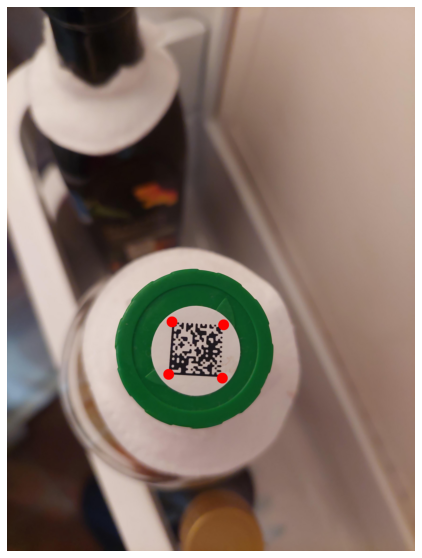

In [161]:
image_path = '/'.join(['augmented_images', d['filename']])

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

p, _ = get_points(d)

visualize_points(image, p)

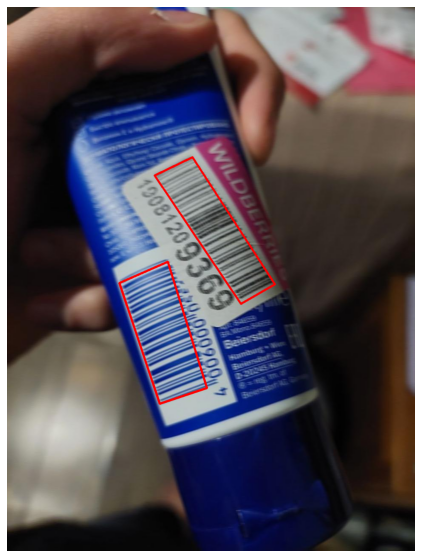

In [14]:
with open('augmented_markup.json', 'r') as f:
    aug_data = json.load(f)

with open('via_project_9Nov2024_20h28m_.json', 'r') as f:
    data = json.load(f)

visualize('augmented_images/photo_2024-10-29_02-35-07_54237.jpg', aug_data)
# visualize('images/photo_2024-10-29_02-35-07.jpg', data)

[(704, 771), (983, 1081), (1343, 816), (1044, 522)]


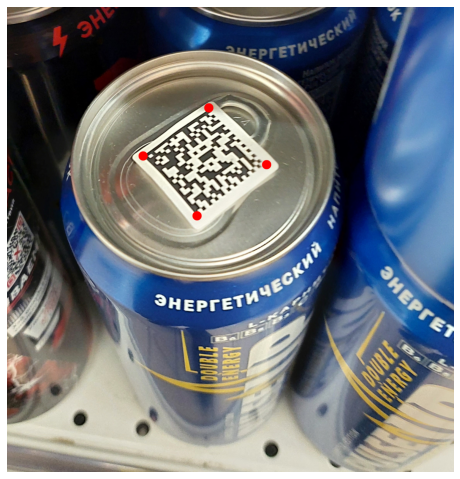

In [145]:
visualize('images/20241104_185308.jpg', data)

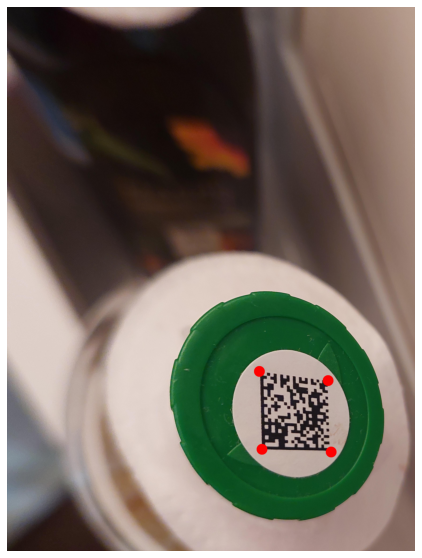

In [ ]:
img = cv2.imread('augmented_images/' + d['filename'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualize_points(img, get_points(d)[0])

In [ ]:
def write_results(initial_data, image_markups_list):
    image_markups_dict = {}
    id_list = []

    for image_markup in image_markups_list:
        curr_file_name = image_markup['filename']
        curr_id = curr_file_name + str(image_markup['size'])
        id_list.append(curr_id)
        image_markups_dict[curr_id] = image_markup

    res_data = dict(initial_data)
    res_data['_via_img_metadata'] = image_markups_dict
    res_data['_via_image_id_list'] = id_list
    return res_data

In [37]:
r = write_results(data, l)

In [34]:
with open("your_file.json", "w") as write_file:
    json.dump(r, write_file)

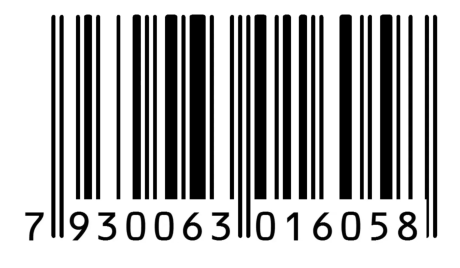

In [ ]:
img = cv2.imread('synthetics/1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(8, 10))

plt.imshow(img, cmap='gray')

In [143]:
x, y = img.shape

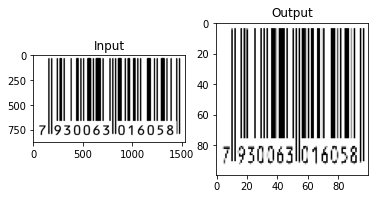

In [ ]:
sz = 100

rows,cols = img.shape
pts1 = np.float32([[0,0],[cols-1,0],[0,rows-1],[cols-1,rows-1]])
pts2 = np.float32([[0,0],[sz,0],[0,sz],[sz,sz]])

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(img,M,(sz,sz))

plt.subplot(121),plt.imshow(img, cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst, cmap='gray'),plt.title('Output')
plt.show()

In [5]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [2]:
def dist(p1, p2):
    """p1 and p2 in format (x1,y1) and (x2,y2) tuples"""
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis

def warp_point(point, M):
    return (
        int((M[0][0] * point[0] + M[0][1] * point[1] + M[0][2]) / (M[2][0] * point[0] + M[2][1] * point[1] + M[2][2])),
        int((M[1][0] * point[0] + M[1][1] * point[1] + M[1][2]) / (M[2][0] * point[0] + M[2][1] * point[1] + M[2][2]))
    )

def calculate_area(x1, y1, x2, y2, x3, y3):
    area = abs((x1 - x3) * (y2 - y1) - (x1 - x2) * (y3 - y1))
    return area


def perspective_transform(img, points, inner_points, alpha):
    sz = min(dist(points[0], points[1]), dist(points[1], points[2]), dist(points[2], points[3]))

    trans_points_ = []
    for point in points:

        angle = random.uniform(0, math.pi)
        length = random.uniform(0, sz * alpha)

        trans_point = (point[0] + length * math.cos(angle), point[1] + length * math.sin(angle))
        trans_point = (int(trans_point[0]), int(trans_point[1]))

        trans_points_.append(trans_point)

    min_x = int(1e4)
    min_y = int(1e4)
    for point in trans_points_:
        min_x = min(min_x, point[0])
        min_y = min(min_y, point[1])

    trans_points = []

    min_x = min(min_x, -10)
    min_y = min(min_y, -10)

    min_x = -min_x
    min_y = -min_y

    max_x = 0
    max_y = 0

    for point in trans_points_:
        trans_points.append([point[0] + min_x, point[1] + min_y])
        max_x = max(max_x, point[0] + min_x)
        max_y = max(max_y, point[1] + min_y)

    M1 = cv2.getPerspectiveTransform(np.float32(points), np.float32(trans_points))
    dst = cv2.warpPerspective(img,M1,(max_x + 10, max_y + 10))
    M2 = cv2.getPerspectiveTransform(np.float32(trans_points), np.float32(points))
    rev = cv2.warpPerspective(dst,M2,(img.shape[1], img.shape[0]))

    inner_modified = []

    min_dist = int(1e4)

    r = 5

    for i, point in enumerate(inner_points):
        cv2.circle(rev, point, r, (255, 0, 0), thickness=-1)
        warped_point = warp_point(point, M1)
        inner_modified.append(warped_point)
        cv2.circle(dst, warped_point, r, (255, 0, 0), thickness=-1)
        if i % 3 == 2:
            p2 = inner_modified[-2]
            p3 = inner_modified[-3]
            
            min_dist = min(min_dist, calculate_area(warped_point[0], warped_point[1], p2[0], p2[1], p3[0], p3[1]))

    return dst, rev, min_dist


In [665]:
# 4.png
x = [33,1568,1566,33]
y = [581,581,25,24]
l = [ [x, y] for (x, y) in zip(x, y) ]

In [599]:
# qr1.png
x = [57,1095,1092,56]
y = [1093,1093,57,56]
l = [ [x, y] for (x, y) in zip(x, y) ]

In [666]:
img = cv2.imread('synthetics/4.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

rows,cols = img.shape
pts1 = np.float32(l)

In [4]:
def create_mask(img1, polygon):
    mask = img1.copy()
    r, c, _ = img1.shape

    for i in range(r):
        for j in range(c):
            mask[i][j] = 1 if polygon.contains(Point(j, i)) else 0

    return mask

In [667]:
res = []

for _ in range(1000):
    dst, rev, t = perspective_transform(img, pts1, 0.5)
    diff = (img - rev) * mask
    # diff = ((img > 20) != (rev > 20)) * mask

    if np.mean(diff) > 30:
        hard_def = dst
        hard = rev

    res.append((t, np.mean(diff)))

x = [ x for (x, y) in res ]
y = [ y for (x, y) in res ]

ValueError: operands could not be broadcast together with shapes (741,1600) (874,1536) 

In [ ]:
img = cv2.imread('synthetics/4.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

x = [33,1568,1566,33]
y = [581,581,25,24]
l = [ [x, y] for (x, y) in zip(x, y) ]

pts1 = np.float32(l)

mask = create_mask(img, Polygon(pts1))

res = []

for _ in range(1000):
    dst, rev, t = perspective_transform(img, pts1, 0.8)
    diff = (img - rev) * mask
    
    # diff = ((img > 20) != (rev > 20)) * mask

    if np.mean(diff) > 30:
        hard_def = dst
        hard = rev

    res.append((t, np.mean(diff)))

x = [ x for (x, y) in res ]
y = [ y for (x, y) in res ]


In [86]:
img = cv2.imread('synthetics/1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

x = [154,1481,1481,151]
y = [664,664,32,29]
l = [ [x, y] for (x, y) in zip(x, y) ]

pts1 = np.float32(l)

mask = create_mask(img, Polygon(pts1))

res = []

for _ in range(1000):
    dst, rev, t = perspective_transform(img, pts1, 0.8)
    diff = (img - rev) * mask
    # diff = ((img > 20) != (rev > 20)) * mask

    if np.mean(diff) > 100:
        hard_def = dst
        hard = rev

    res.append((t, np.mean(diff)))

x = [ x for (x, y) in res ]
y = [ y for (x, y) in res ]


ValueError: not enough values to unpack (expected 3, got 2)

In [668]:
img = cv2.imread('synthetics/4.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

x = [33,1568,1566,33]
y = [581,581,25,24]
l = [ [x, y] for (x, y) in zip(x, y) ]

pts1 = np.float32(l)

mask = create_mask(img, Polygon(pts1))

res = []

for _ in range(1000):
    dst, rev, t = perspective_transform(img, pts1, 0.8)
    diff = (img - rev) * mask
    # diff = ((img > 20) != (rev > 20)) * mask

    if np.mean(diff) > 30:
        hard_def = dst
        hard = rev

    res.append((t, np.mean(diff)))

x = [ x for (x, y) in res ]
y = [ y for (x, y) in res ]


In [7]:
img = cv2.imread('synthetics/qr1_small.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# qr1.png
x = [14,273,273,14]
y = [273,273,14,14]
l = [ [x, y] for (x, y) in zip(x, y) ]

inner_points = [(json.loads(d)['cx'], json.loads(d)['cy']) for d in pd.read_csv('inner_points_small.csv')['region_shape_attributes']]

pts1 = np.float32(l)

mask = create_mask(img, Polygon(pts1))

res_sm = []

d_dst_sm = {}
d_rev_sm = {}

for _ in range(10000):
    dst, rev, t = perspective_transform(img, pts1, inner_points, 0.49)
    diff = (img - rev) * mask

    m = np.mean(diff)

    d_dst_sm[ (m // 5) * 5 ] = dst
    d_rev_sm[ (m // 5) * 5 ] = rev

    res_sm.append((t, m))

x_sm = [ x for (x, y) in res_sm ]
y_sm = [ y for (x, y) in res_sm ]


Text(0, 0.5, 'ошибка')

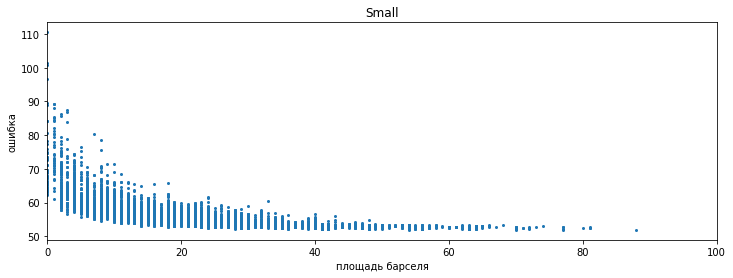

In [26]:
plt.figure(figsize=(12, 4))
plt.scatter(x_sm, y_sm, s=4)
plt.title('Small')
plt.xlabel('площадь барселя')
plt.xlim((0, 100))
plt.ylabel('ошибка')

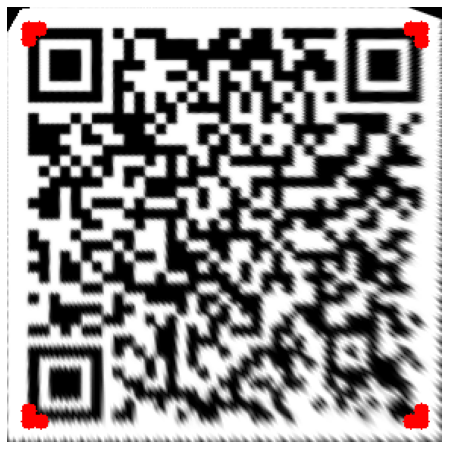

In [31]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(d_dst_sm[70], cmap='gray')
plt.imshow(d_rev_sm[70], cmap='gray')

In [12]:
img = cv2.imread('synthetics/qr1_medium.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# qr1.png
x = [27,546,546,27]
y = [546,546,27,27]
l = [ [x, y] for (x, y) in zip(x, y) ]

inner_points = [(json.loads(d)['cx'], json.loads(d)['cy']) for d in pd.read_csv('inner_points_medium.csv')['region_shape_attributes']]

pts1 = np.float32(l)

mask = create_mask(img, Polygon(pts1))

res_med = []

d_dst_med = {}
d_rev_med = {}

for _ in range(10000):
    dst, rev, t = perspective_transform(img, pts1, inner_points, 0.49)
    diff = (img - rev) * mask

    m = np.mean(diff)

    d_dst_med[ (m // 5) * 5 ] = dst
    d_rev_med[ (m // 5) * 5 ] = rev

    res_med.append((t, m))

x_med = [ x for (x, y) in res_med ]
y_med = [ y for (x, y) in res_med ]


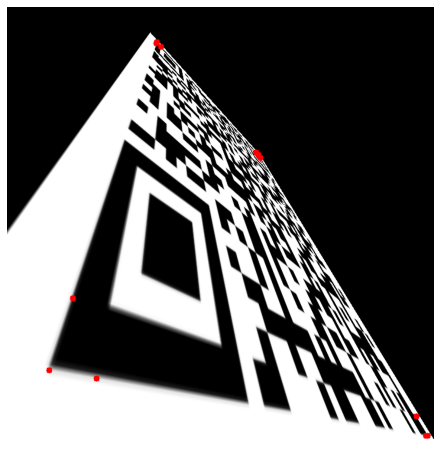

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(d_dst_med[55], cmap='gray')
plt.imshow(d_rev_med[55], cmap='gray')

Text(0, 0.5, 'ошибка')

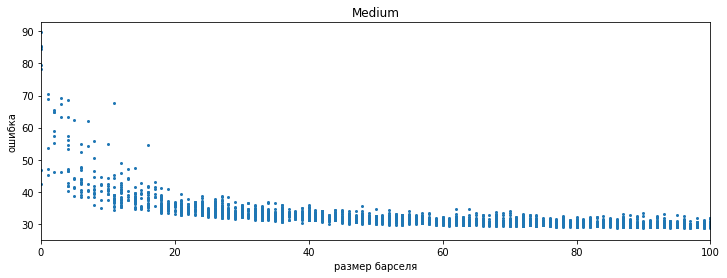

In [35]:
plt.figure(figsize=(12, 4))
plt.scatter(x_med, y_med, s=4)
plt.title('Medium')
plt.xlabel('размер барселя')
plt.xlim((0, 100))
plt.ylabel('ошибка')

In [17]:
img = cv2.imread('synthetics/qr1.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# qr1.png
x = [57,1095,1092,56]
y = [1093,1093,57,56]
l = [ [x, y] for (x, y) in zip(x, y) ]

inner_points = [(json.loads(d)['cx'], json.loads(d)['cy']) for d in pd.read_csv('inner_points_big.csv')['region_shape_attributes']]

pts1 = np.float32(l)

mask = create_mask(img, Polygon(pts1))

res_big = []

d_dst_big = {}
d_rev_big = {}

for _ in range(10000):
    dst, rev, t = perspective_transform(img, pts1, inner_points, 0.49)
    diff = (img - rev) * mask

    m = np.mean(diff)

    d_dst_big[ (m // 5) * 5 ] = dst
    d_rev_big[ (m // 5) * 5 ] = rev

    res_big.append((t, m))

x_big = [ x for (x, y) in res_big ]
y_big = [ y for (x, y) in res_big ]


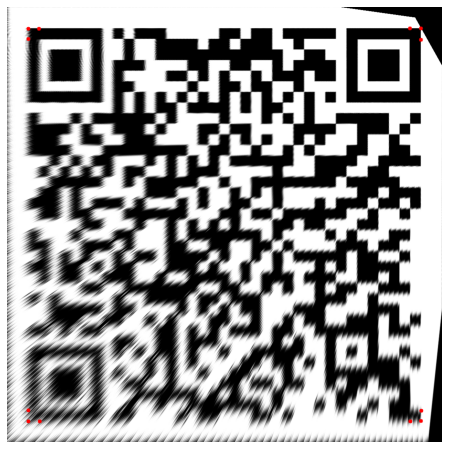

In [45]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(d_dst_big[40], cmap='gray')
plt.imshow(d_rev_big[40], cmap='gray')

Text(0, 0.5, 'ошибка')

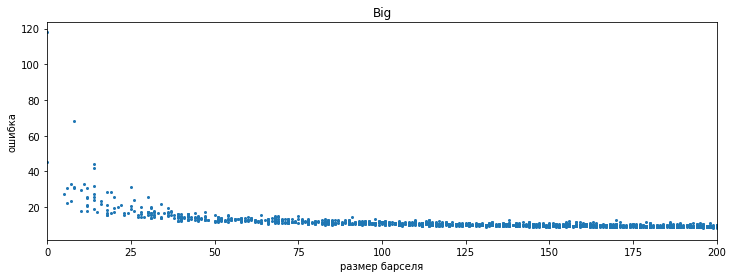

In [39]:
plt.figure(figsize=(12, 4))
plt.scatter(x_big, y_big, s=4)
plt.title('Big')
plt.xlabel('размер барселя')
plt.xlim((0, 200))
plt.ylabel('ошибка')